<a href="https://colab.research.google.com/github/federicodeluca/-CNN_mnist_dataset/blob/main/Copia_di_%5BDL%5D_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN_Classification_MNIST_FashionMNIST



In [ ]:
%matplotlib inline
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We can check whether we have GPUs available:

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## MNIST data set

Next we'll load the MNIST handwritten digits data set.  First time we may have to download the data, which can take a while. MNIST è un dataset di immagini in scala di grigi di cifre scritte a mano (da 0 a 9)


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor() #Converte le immagini PIL in tensori PyTorch (necessari per il training)

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform) #training set 60k immagini
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform) #test set 10k immagini

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.41MB/s]


# BATCH
Se ho 1.000 immagini nel dataset, e imposto batch_size = 32, allora il modello vedrà 32 immagini alla volta.
Serviranno circa 1000 ÷ 32 passaggi per vedere l’intero dataset una volta (questo si chiama epoch). Questo velocizza il calcolo grazie al parallelismo per questo usiamo la GPU!

# TENSORE
Un tensore è una struttura dati (come array o matrici) che può avere più dimensioni. È la base di come PyTorch rappresenta dati numerici, come immagini, vettori o output dei modelli.

Prendiamo ora le prime 20 immagini e le plottiamo (per farlo dobbiamo passare a degli array, stampiamo anche le relative etichette sopra)

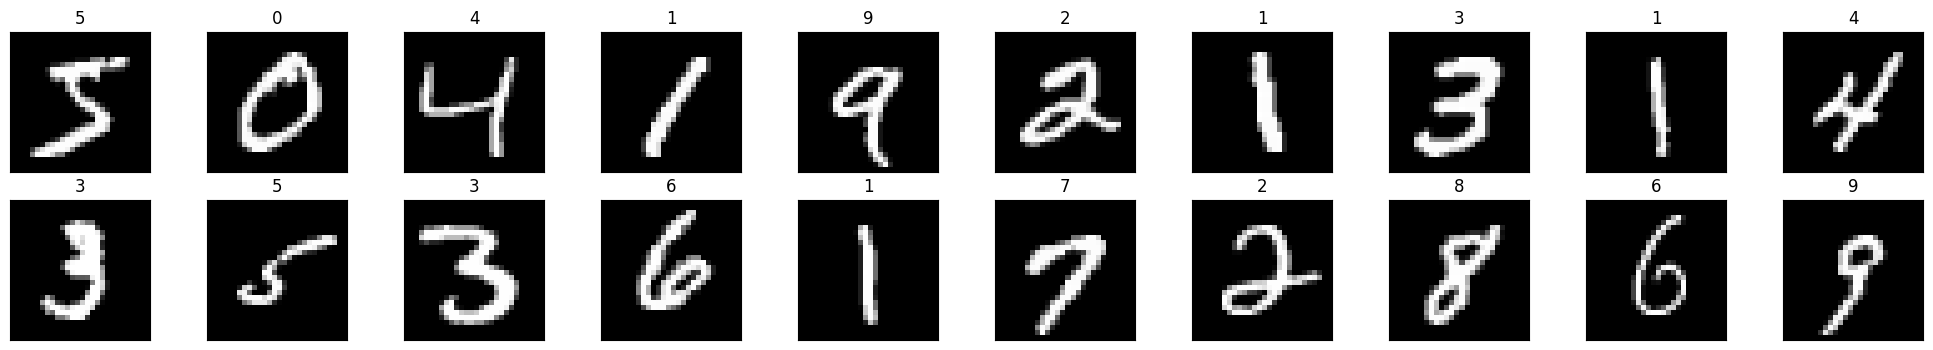

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

View an Image in More Detail

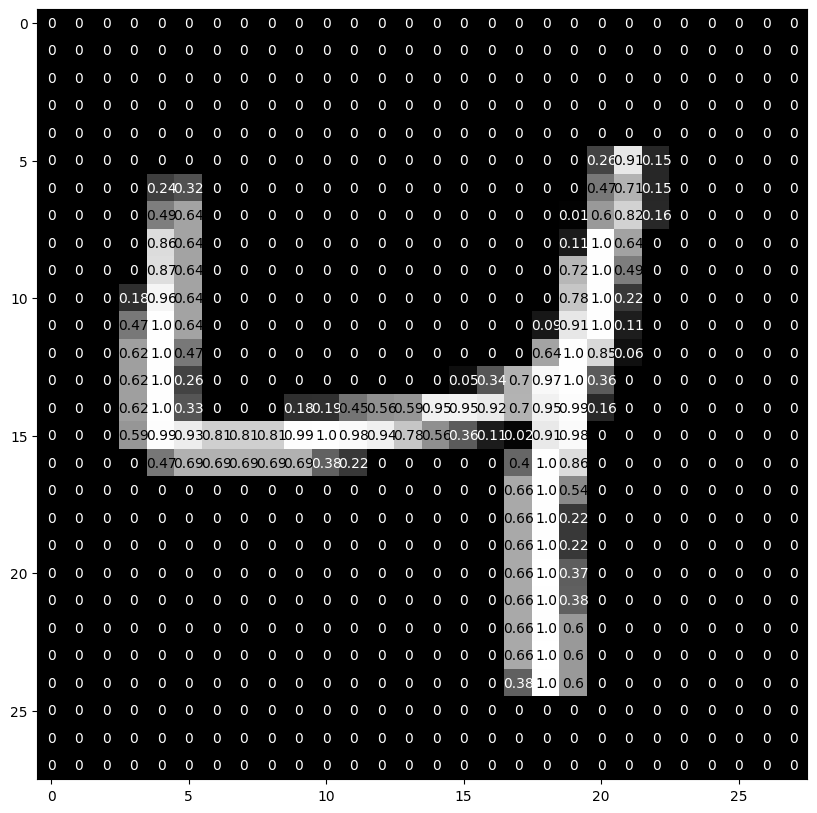

In [ ]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

I numeri su ogni punto dell'immagine (cioè ogni pixel) sono stati ricavati direttamente dal file dell'immagine stessa, e rappresentano l’intensità della luce in scala di grigi in quel punto.

Ogni pixel ha un valore numerico compreso tra 0 e 1:



*  0.0 = completamente nero
*  1.0 = completamente bianco
*  Valori tra 0 e 1 = varie sfumature di grigio

PyTorch, con datasets.MNIST(...) e transforms.ToTensor(), li legge e converte automaticamente in tensori di numeri reali.

## Convolutional Neural Networks (CNNs)
A Convolutional Neural Network is type of neural network that is used mainly in image processing applications.

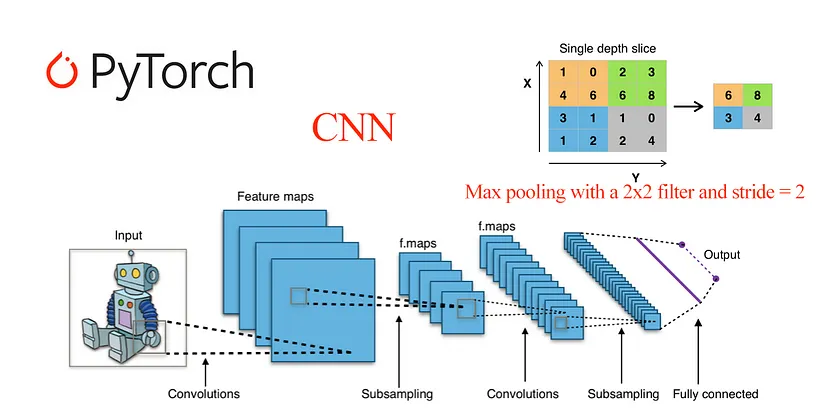

It relies, basicly, on two particular layer designed specifically for image processing:


*   **Convolutional layer**
*   **Pooling layer**



### Convolutional layer

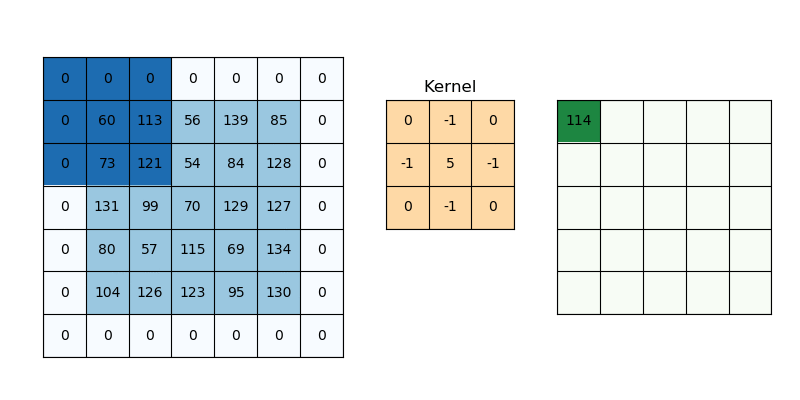

The **convolutional layer** operates using filters(or kernels, or masks), which are parametric matrices of predefined size that scan an image step-by-step and iteratively operate on subsets of pixels, obtaining feature maps of size:

$$mapSize = \dfrac{inputSize − filterSize + 2 \cdot padding}{stride}+1$$

where

`inputSize` is the size of the image

`filterSize` is the size of the filter

`padding` is the margin of 0 optionally added to the image

`stride` determines the size of the 'sliding' step of the filter on the image

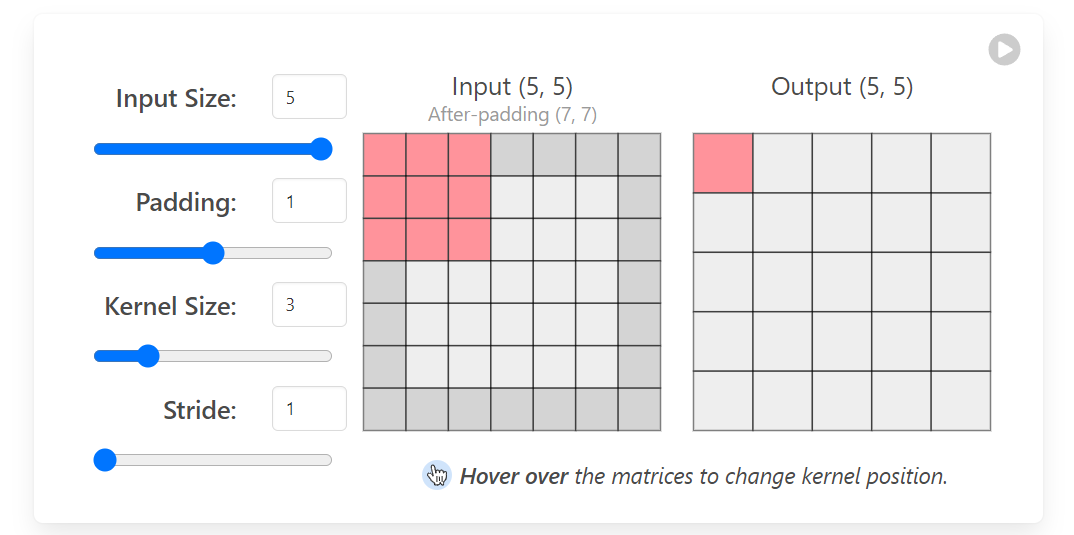

In [ ]:
# Function that compute the output map size given several hyperparameters
def compute_map_size(input_size, filter_size, padding, stride):

    map_size = ((input_size - filter_size + 2 * padding) // stride) + 1
    return map_size


input_size = 28
filter_size = 5
padding = 2
stride = 1
result = compute_map_size(input_size, filter_size, padding, stride)
print(f"Map size: {result}")

Map size: 28


The number of parameters of this layer will be given by the cardinality of the resulting tensor as the product of `filterSize` and `num_filters`.

$$num\_parameters = filterSize \cdot num\_filters+ num\_filters$$ (considering the bias).

Technically, the convolution operation occurs by performing the linear combination of the elements of the filter matrix with the corresponding elements of the subset of pixels being observed, adding a bias.

Intuitively, the determining factor compared to a classic MLP is therefore the ability, through convolution with multiple filters, to observe spatial relationships among input pixels: the parameters of each filter can be trained, so the values change in such a way as to build more promising filters to detect pixel geometries, hence to recognize visual patterns such as edges, contours, and more complex shapes.

In fact, the pixels, convolutional layer after convolutional layer, are represented in a space of more abstract features, whose combination will be more suitable for making the final decision.

\\

Furthermore we can obtain the number of output values ​​of a generic convolutional layer using:

$$outputSize = mapSize \cdot num\_filters$$

### Pooling layer

The **Pooling layer**, for instance a **MaxPooling layer**, is a layer that traverses the feature maps and computes more compact representations of them, considering only the pixels with maximum value for each subset of pixels belonging to the feature maps. It is useful for controlling the number of parameters, reducing the complexity of the model. It has no trainable parameters.


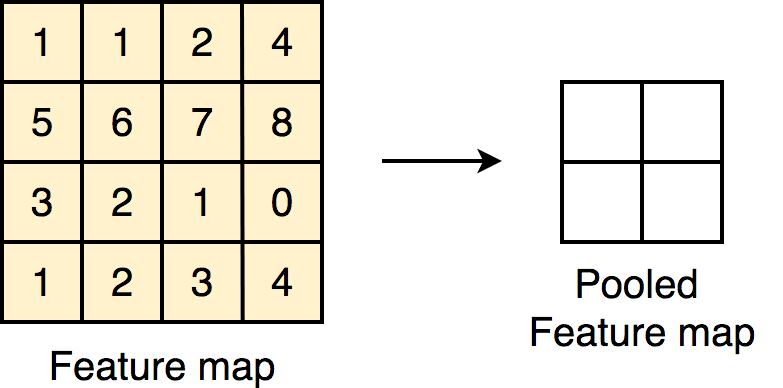

## CNN model design

In [ ]:
import torch.nn as nn

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #primo blocco convoluzionale sostanzialmente produce 16 feature map, convoluzione con filtro 5x5, padding 2
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1, # we will use grey-scale values
            out_channels=16, #16 differenti feature map ognuna delle quali impara qualcosa di diverso.
            kernel_size=5, # 5x5 matrix to perform the convolution
            stride=1,
            padding=2,
        ),

        nn.ReLU(), #attivazione non lineare, sostanzialmente se è il valore della cella della feature map è negativo mette 0 è come dire non ci interessa questa informazione
        nn.MaxPool2d(kernel_size=2), #dimezza le dimensioni spaziali
#Le immagini del dataset sono 28x28, output size della feature map diventa:

#output_size = 28(input_size) + 2*2(padding) - (kernel size =5) / stride = 1 + 1 = 28
#poi applico la divisione per il maxpooling ottengo 16 feature map di 14x14

        #da qui escono 16 feture map da 14x14
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
#qui escono 32 feature map, la output_size è sempre 14x14 che con il max pooling diventa la metà 7x7


#questo strato lavora con i vettori non più con le matrici prende in input un vettore e produce in output 10 numeri (da 1 a 9)
    # fully connected layer, output 10 classes
    self.out = nn.Linear(32 * 7 * 7, 10) # notice here, 32 refers to the number of output feature maps from the previous layers, and 7x7 is the spatial dimension of each feature map produced by those layers.
# rappresenta il numero di input della fully connected layer.
#Deriva dalla forma del tensore di output che esce dalla seconda convoluzione e pooling.
  def forward(self, x):
    x = self.conv1(x) #eseguo le convoluzioni fatte prima nel mio metodo forward
    x = self.conv2(x)

    # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
    x = x.view(x.size(0), -1)  #Il flattening trasforma un tensore multidimensionale in un vettore monodimensionale. Questo è necessario perché i fully connected layer (nn.Linear) lavorano con vettori, non con immagini o matrici.
    output = self.out(x)
    return output, x    # return x for visualization

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Define here the loss function and the optimizer to apply to the model parameters.

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01) #learning rate ci dice quanto sono grandi i passi durante la discesa del gradiente
#utilizzo l'ottimizzatore adam
#Adam è un algoritmo che migliora il classico SGD (Stochastic Gradient Descent) combinando adattativamente velocità e momento.
print(optimizer)

loss_func = nn.CrossEntropyLoss() #più è bassa meglio è
print(loss_func)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


I betas sono i parametri che controllano il momento (quanto "memoria" degli aggiornamenti passati si tiene)

wieght decay = 0 nessuna regolarizzazione...

## Train the model
Create a function called `train()` and pass number of epochs, model and data loaders as input parameters.

`num_epochs`: Number of times our model will go through the entire training dataset

In [ ]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, model, train_loader):

  model.train() #imposto la modalità di training

  # Train the model
  total_step = len(train_loader) #quanti batch ci sono in un epoca completa Un batch è un gruppo di immagini (o dati) che passi insieme alla rete in un singolo passo (una sola volta nel forward + backward).
#Invece di passare una sola immagine alla volta (che sarebbe lento) o tutto il dataset insieme (che consumerebbe troppa memoria), si fa una via di mezzo:
#Si prendono piccoli gruppi di immagini → mini-batch.

#Dopo aver calcolato il loss e fatto il backpropagation su quelle 100 immagini, aggiorna i pesi.
#Poi si passa al prossimo batch di altre 100 immagini.
#Dopo 600 batch ha visto tutto il dataset una volta → 1 epoca.



  for epoch in range(num_epochs): #10 volte passiamo il dataset
    for i, (images, labels) in enumerate(train_loader):

      # gives batch data, normalize x when iterate train_loader
      b_x = Variable(images)   # batch x
      b_y = Variable(labels)   # batch y

#batch_size = 100 immagini MNIST (28x28)
#b_x avrà shape (100, 1, 28, 28) → 100 immagini, 1 canale, 28x28 pixel. Batch variabili
#b_y avrà shape (100,) → 100 numeri interi (da 0 a 9). Batch etichette
      output = model(b_x)[0]

# l'output del mio modello CNN restituiva i punteggi e il vettore
# flattened che ignoriamo prendendo solo [0]

#poi calcolo la mia funzione di loss
      loss = loss_func(output, b_y)



      # clear gradients for this training step perchè pyhtorch li accumula per ogni batch
      optimizer.zero_grad()

      # backpropagation, compute gradients calcolo i gradienti della funzione di loss rispetto ai pesi e ai bias
      # è il backpropagation classico per aggiornare i pesi
      loss.backward()
      # apply gradients: Aggiorna i pesi della rete usando i gradienti appena calcolati e seguendo l'algoritmo scelto (Adam) ci spostiamo nella direzione che riduce la loss
      optimizer.step()

      if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))



In [ ]:
train(10, cnn, train_loader)

Epoch [1/10], Step [100/1875], Loss: 0.1242
Epoch [1/10], Step [200/1875], Loss: 0.2176
Epoch [1/10], Step [300/1875], Loss: 0.3458
Epoch [1/10], Step [400/1875], Loss: 0.1483
Epoch [1/10], Step [500/1875], Loss: 0.1754
Epoch [1/10], Step [600/1875], Loss: 0.2614
Epoch [1/10], Step [700/1875], Loss: 0.0150
Epoch [1/10], Step [800/1875], Loss: 0.0244
Epoch [1/10], Step [900/1875], Loss: 0.2922
Epoch [1/10], Step [1000/1875], Loss: 0.0444
Epoch [1/10], Step [1100/1875], Loss: 0.1056
Epoch [1/10], Step [1200/1875], Loss: 0.4453
Epoch [1/10], Step [1300/1875], Loss: 0.2590
Epoch [1/10], Step [1400/1875], Loss: 0.0407
Epoch [1/10], Step [1500/1875], Loss: 0.0173
Epoch [1/10], Step [1600/1875], Loss: 0.0060
Epoch [1/10], Step [1700/1875], Loss: 0.0764
Epoch [1/10], Step [1800/1875], Loss: 0.0150
Epoch [2/10], Step [100/1875], Loss: 0.0831
Epoch [2/10], Step [200/1875], Loss: 0.2145
Epoch [2/10], Step [300/1875], Loss: 0.1293
Epoch [2/10], Step [400/1875], Loss: 0.1547
Epoch [2/10], Step [500

## Evaluate the model on test data
We must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.

`model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

You can call either `model.eval()` or `model.train(mode=False)` to tell that you are testing the model.

Dobbiamo vedere ora sul test set quanto lavora bene il nostro modello (test_loader). Prima in fase di evaluation (valutazione) dove i layer di Dropout e BathcNorm si comportano in modo diverso tra training e test set

In [ ]:
def test(model, test_loader):
  # Test the model
  model.eval()
  correct = 0
  total = len(test_loader.dataset)

  with torch.no_grad(): #disattiviamo i gradienti nella fase di test non serve

    for images, labels in test_loader:

      test_output, _ = model(images) #passiamo l'immagine e poi prendiamo il max tra i logists cioè i punteggi delle 10 classi
      pred_y = torch.max(test_output, 1)[1].data.squeeze() #troviamo la classe con il max punteggio per ogni immagine

      correct += (pred_y == labels).sum().item() #confronta le predizioni con le etichette vere



  print(f'Test Accuracy of the model on the test images: {correct/total}')


In [ ]:
test(cnn, test_loader)

Test Accuracy of the model on the test images: 0.9596


In [ ]:
iterable = iter(test_loader)
sample = next(iterable)

sample = next(iterable)
imgs, lbls = sample
actual_number = lbls.numpy()

test_output, last_layer = cnn(imgs)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: \t{pred_y}')
print(f'Actual number: \t\t{actual_number}')

Prediction number: 	[3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]
Actual number: 		[3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


## Exercise 1
Optimize the CNN model: add layers (convolution, poolings, dropouts, etc) in order to increase the performance. Evaluate it for comparison with the previous CNN model and MLP model. Then write a simple table with the accuracy measure for the models: which one is better? Why? Discuss briefly your results.

# SVOLGIMENTO ESERCIZI
In questa esercitazione sono stati progettati e confrontati tre modelli convoluzionali per la classificazione del dataset Fashion-MNIST. Il primo modello, CNN_3Conv, introduce tre blocchi convoluzionali con ReLU e MaxPooling, portando le immagini da 28×28 a 3×3, seguiti da un layer fully connected. Si tratta di una rete compatta, ma già sufficientemente espressiva da ottenere buoni risultati. La seconda versione, CNN_3Conv con Dropout, mantiene la stessa struttura, ma introduce un meccanismo di regolarizzazione tramite un layer di dropout con probabilità del 50%, posizionato prima del classificatore finale: questo migliora la capacità del modello di generalizzare, soprattutto nei casi in cui tende a sovra-adattarsi ai dati di training. Infine, il modello più avanzato, CNN_Deep, adotta un’architettura più sistematica e profonda, composta da due blocchi simmetrici da due convoluzioni ciascuno, alternati da ReLU e pooling. Anche qui è presente il dropout, ma abbinato a un design più modulare e profondo, che permette di apprendere rappresentazioni più ricche. I risultati ottenuti evidenziano un chiaro miglioramento nell'accuratezza e nella stabilità del modello man mano che la rete diventa più strutturata e regolarizzata, confermando che non è solo la profondità a fare la differenza, ma una progettazione consapevole dell’intera pipeline convoluzionale.

PRIMA MODIFICA passaggio da 2 a 3 layer convoluzionali, vediamo quanto impatta l'aggiunta di un nuovo strato, una piccola modifica che facciamo è cambiare anche il learning rate nell'ottimizzatore (facciamo dei passi leggermente più piccoli)

In [ ]:
class CNN_3Conv(nn.Module):
  def __init__(self):
    super(CNN_3Conv, self).__init__()
    #primo blocco convoluzionale sostanzialmente produce 16 feature map, convoluzione con filtro 5x5, padding 2
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1, # we will use grey-scale values
            out_channels=16, #16 differenti feature map ognuna delle quali impara qualcosa di diverso.
            kernel_size=5, # 5x5 matrix to perform the convolution
            stride=1,
            padding=2,
        ),

        nn.ReLU(), #attivazione non lineare, sostanzialmente se è il valore della cella della feature map è negativo mette 0 è come dire non ci interessa questa informazione
        nn.MaxPool2d(kernel_size=2), #dimezza le dimensioni spaziali
#Le immagini del dataset sono 28x28, output size della feature map diventa:

#output_size = 28(input_size) + 2*2(padding) - (kernel size =5) / stride = 1 + 1 = 28
#poi applico la divisione per il maxpooling ottengo 16 feature map di 14x14

        #da qui escono 16 feture map da 14x14
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
#qui escono 32 feature map, la output_size è sempre 14x14 che con il max pooling diventa la metà 7x7
#ESERCIZIO_1: aggiungiamo banalmente un nuovo layer, questo manterrà sempre la dimensione 7x7 ma poi con il maxpooling diventa 3x3
    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

#questo strato lavora con i vettori non più con le matrici prende in input un vettore e produce in output 10 numeri (da 1 a 9)
    # fully connected layer, output 10 classes
    self.out = nn.Linear(64 * 3 * 3, 10)  # notice here, 64 refers to the number of output feature maps from the previous layers, and 3x3 is the spatial dimension of each feature map produced by those layers.
# rappresenta il numero di input della fully connected layer.
#Deriva dalla forma del tensore di output che esce dalla seconda convoluzione e pooling.
  def forward(self, x):
    x = self.conv1(x) #eseguo le convoluzioni fatte prima nel mio metodo forward
    x = self.conv2(x)
    x = self.conv3(x)

    # flatten the output of conv2 to (batch_size, 64 * 3 * 3)
    x = x.view(x.size(0), -1)  #Il flattening trasforma un tensore multidimensionale in un vettore monodimensionale. Questo è necessario perché i fully connected layer (nn.Linear) lavorano con vettori, non con immagini o matrici.
    output = self.out(x)
    return output, x    # return x for visualization

In [ ]:
cnn3 = CNN_3Conv()


In [ ]:
optimizer = optim.Adam(cnn3.parameters(), lr=0.001)


In [ ]:
train(10, cnn3, train_loader)


Epoch [1/10], Step [100/1875], Loss: 0.1531
Epoch [1/10], Step [200/1875], Loss: 0.1026
Epoch [1/10], Step [300/1875], Loss: 0.2407
Epoch [1/10], Step [400/1875], Loss: 0.2184
Epoch [1/10], Step [500/1875], Loss: 0.0517
Epoch [1/10], Step [600/1875], Loss: 0.0690
Epoch [1/10], Step [700/1875], Loss: 0.0080
Epoch [1/10], Step [800/1875], Loss: 0.0063
Epoch [1/10], Step [900/1875], Loss: 0.3095
Epoch [1/10], Step [1000/1875], Loss: 0.0089
Epoch [1/10], Step [1100/1875], Loss: 0.0387
Epoch [1/10], Step [1200/1875], Loss: 0.2561
Epoch [1/10], Step [1300/1875], Loss: 0.0199
Epoch [1/10], Step [1400/1875], Loss: 0.0406
Epoch [1/10], Step [1500/1875], Loss: 0.0133
Epoch [1/10], Step [1600/1875], Loss: 0.0061
Epoch [1/10], Step [1700/1875], Loss: 0.0073
Epoch [1/10], Step [1800/1875], Loss: 0.0066
Epoch [2/10], Step [100/1875], Loss: 0.0087
Epoch [2/10], Step [200/1875], Loss: 0.0050
Epoch [2/10], Step [300/1875], Loss: 0.0560
Epoch [2/10], Step [400/1875], Loss: 0.1136
Epoch [2/10], Step [500

In [ ]:
test(cnn3, test_loader)

Test Accuracy of the model on the test images: 0.9894


L'accuracy migliora notevolmente otteniamo 0.9894 un risultato soprendente con la sola aggiunta di un layer.

MODELLO 2: Definiamo un nuovo modello che prevede il dropout ovvero lo spegnimento di alcuni neuroni in modo casuale per evitare overfitting.


In [ ]:
class CNN_3Conv_dropout(nn.Module):
  def __init__(self):
    super(CNN_3Conv_dropout, self).__init__()
    #primo blocco convoluzionale sostanzialmente produce 16 feature map, convoluzione con filtro 5x5, padding 2
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1, # we will use grey-scale values
            out_channels=16, #16 differenti feature map ognuna delle quali impara qualcosa di diverso.
            kernel_size=5, # 5x5 matrix to perform the convolution
            stride=1,
            padding=2,
        ),

        nn.ReLU(), #attivazione non lineare, sostanzialmente se è il valore della cella della feature map è negativo mette 0 è come dire non ci interessa questa informazione
        nn.MaxPool2d(kernel_size=2), #dimezza le dimensioni spaziali
#Le immagini del dataset sono 28x28, output size della feature map diventa:

#output_size = 28(input_size) + 2*2(padding) - (kernel size =5) / stride = 1 + 1 = 28
#poi applico la divisione per il maxpooling ottengo 16 feature map di 14x14

        #da qui escono 16 feture map da 14x14
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
#qui escono 32 feature map, la output_size è sempre 14x14 che con il max pooling diventa la metà 7x7
#ESERCIZIO_1: aggiungiamo banalmente un nuovo layer, questo manterrà sempre la dimensione 7x7 ma poi con il maxpooling diventa 3x3
    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, 5, 1, 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.dropout = nn.Dropout(0.5)
#questo strato lavora con i vettori non più con le matrici prende in input un vettore e produce in output 10 numeri (da 1 a 9)
    # fully connected layer, output 10 classes
    self.out = nn.Linear(64 * 3 * 3, 10)  # notice here, 64 refers to the number of output feature maps from the previous layers, and 3x3 is the spatial dimension of each feature map produced by those layers.
# rappresenta il numero di input della fully connected layer.
#Deriva dalla forma del tensore di output che esce dalla seconda convoluzione e pooling.
  def forward(self, x):
    x = self.conv1(x) #eseguo le convoluzioni fatte prima nel mio metodo forward
    x = self.conv2(x)
    x = self.conv3(x)

    # flatten the output of conv2 to (batch_size, 64 * 3 * 3)
    x = x.view(x.size(0), -1)  #Il flattening trasforma un tensore multidimensionale in un vettore monodimensionale. Questo è necessario perché i fully connected layer (nn.Linear) lavorano con vettori, non con immagini o matrici.
    x = self.dropout(x)
    output = self.out(x)
    return output, x    # return x for visualization

In [ ]:
cnn3_dropout = CNN_3Conv_dropout()
optimizer = optim.Adam(cnn3_dropout.parameters(), lr=0.001)

train(num_epochs, cnn3_dropout, train_loader)
test(cnn3_dropout, test_loader)


Epoch [1/10], Step [100/1875], Loss: 0.3391
Epoch [1/10], Step [200/1875], Loss: 0.1497
Epoch [1/10], Step [300/1875], Loss: 0.2980
Epoch [1/10], Step [400/1875], Loss: 0.3452
Epoch [1/10], Step [500/1875], Loss: 0.1493
Epoch [1/10], Step [600/1875], Loss: 0.1445
Epoch [1/10], Step [700/1875], Loss: 0.0991
Epoch [1/10], Step [800/1875], Loss: 0.0572
Epoch [1/10], Step [900/1875], Loss: 0.2106
Epoch [1/10], Step [1000/1875], Loss: 0.0414
Epoch [1/10], Step [1100/1875], Loss: 0.0474
Epoch [1/10], Step [1200/1875], Loss: 0.3387
Epoch [1/10], Step [1300/1875], Loss: 0.1083
Epoch [1/10], Step [1400/1875], Loss: 0.1135
Epoch [1/10], Step [1500/1875], Loss: 0.0789
Epoch [1/10], Step [1600/1875], Loss: 0.0483
Epoch [1/10], Step [1700/1875], Loss: 0.0435
Epoch [1/10], Step [1800/1875], Loss: 0.0139
Epoch [2/10], Step [100/1875], Loss: 0.0177
Epoch [2/10], Step [200/1875], Loss: 0.0120
Epoch [2/10], Step [300/1875], Loss: 0.0640
Epoch [2/10], Step [400/1875], Loss: 0.2083
Epoch [2/10], Step [500

L'accuracy migliora ancora grazie al dropout, arriviamo al 99,32% un ottimo risultato rispetto alla complessità della rete.


Cercando su internet ho trovato questo sito molto interessante che riporta il benchmark su questo dataset https://paperswithcode.com/sota/image-classification-on-mnist?metric=Accuracy

Sembrerebbe che ci posizioniamo in 21esima posizione, davanti a modelli molto più complessi. Questo ci fa capire che spesso usare un modello più semplice può portare comunque a risultati migliori


Da alcuni modelli presenti sul sito ci viene suggerita una stuttura a blocchi in cui vengono fatte prima due convoluzioni e poi il pooling.

Il modello CNN_Deep è una rete convoluzionale più profonda rispetto alle versioni precedenti, progettata per migliorare la capacità di estrazione delle caratteristiche visive dalle immagini. La rete è composta da due blocchi principali, ognuno formato da due convoluzioni consecutive, seguite da attivazioni ReLU e da un layer di MaxPooling che dimezza le dimensioni spaziali delle feature map. Questo schema consente al modello di apprendere rappresentazioni sempre più astratte man mano che si procede nei livelli. In particolare, il primo blocco trasforma l’input da 28x28 a 14x14, mentre il secondo blocco lo riduce ulteriormente a 7x7. Alla fine dei blocchi convoluzionali, il tensore risultante viene appiattito (flatten), passa attraverso un layer di dropout con probabilità 0.5 (per prevenire l’overfitting), e infine raggiunge un layer completamente connesso (fully connected) che restituisce la predizione finale su 10 classi. Otteniamo un'accuracy di circa 2 punti percentuale maggiore delle precedenti.

In [ ]:
import torch.nn as nn

class CNN_Deep(nn.Module):
    def __init__(self):
        super(CNN_Deep, self).__init__()

        self.conv_layers = nn.Sequential(
            # Primo blocco: 2 convoluzioni + ReLU + MaxPool
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 28x28 → 14x14

            # Secondo blocco: 2 convoluzioni + ReLU + MaxPool
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 14x14 → 7x7
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 7 * 7, 10)  # Output finale: 10 classi

    def forward(self, x):
        x = self.conv_layers(x)                 # Applica blocchi convoluzionali
        x = x.view(x.size(0), -1)               # Flatten: (batch, 64*7*7)
        x = self.dropout(x)                     # Dropout
        output = self.fc(x)                     # Fully connected
        return output, x


In [ ]:
model = CNN_Deep()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(10, model, train_loader)
test(model, test_loader)


Epoch [1/10], Step [100/1875], Loss: 0.2987
Epoch [1/10], Step [200/1875], Loss: 0.1273
Epoch [1/10], Step [300/1875], Loss: 0.2402
Epoch [1/10], Step [400/1875], Loss: 0.1480
Epoch [1/10], Step [500/1875], Loss: 0.0636
Epoch [1/10], Step [600/1875], Loss: 0.2006
Epoch [1/10], Step [700/1875], Loss: 0.0186
Epoch [1/10], Step [800/1875], Loss: 0.0303
Epoch [1/10], Step [900/1875], Loss: 0.2844
Epoch [1/10], Step [1000/1875], Loss: 0.0254
Epoch [1/10], Step [1100/1875], Loss: 0.0254
Epoch [1/10], Step [1200/1875], Loss: 0.2072
Epoch [1/10], Step [1300/1875], Loss: 0.0717
Epoch [1/10], Step [1400/1875], Loss: 0.0142
Epoch [1/10], Step [1500/1875], Loss: 0.0196
Epoch [1/10], Step [1600/1875], Loss: 0.0112
Epoch [1/10], Step [1700/1875], Loss: 0.0541
Epoch [1/10], Step [1800/1875], Loss: 0.0152
Epoch [2/10], Step [100/1875], Loss: 0.0103
Epoch [2/10], Step [200/1875], Loss: 0.0184
Epoch [2/10], Step [300/1875], Loss: 0.0561
Epoch [2/10], Step [400/1875], Loss: 0.0865
Epoch [2/10], Step [500

Nonostante l'archittetura è diventata più complessa, l'accuracy del modelo rimane identica.

## Exercise 2

Replicate the work done in exercise 1 on dataset Fashion MNIST

Fashion-MNIST

Alternatively, MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST.   Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot

**Hint**

Importiamo il nuovo dataset e applichiamo i 3 modelli sviluppati sopra

In [ ]:
###Loading dataset
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]


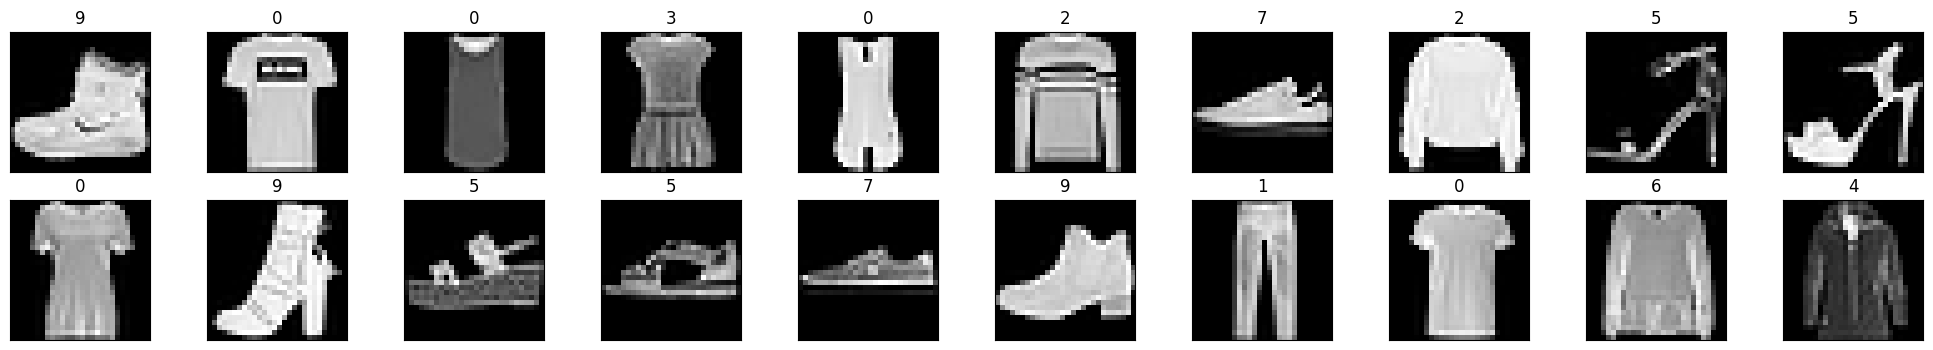

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

NOTA: i modelli precedenti e i seguenti sono stati trainati solo con 10 epoche (relativamente epoche), si può pensare che aumentandone il numero si ottengano risultati ancora migliori. I limiti di utilizzo di GoogleColab per la GPU però non mi permettono di effettuare test più dispendiosi gratuitamente.

MODELLO 1 CNN_3Conv: 3 layer convoluzionali senza dropout (per l'archittetura precisa con le effettive dimensioni si rimanda al commento dove è definita la classe).

In [ ]:
#Assicurarsi che venga fatta girare il blocco della cella che carica il nuovo dataset per le variabili train loader e test loader
model = CNN_3Conv()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(10, model, train_loader)
test(model, test_loader)

Epoch [1/10], Step [100/1875], Loss: 0.8872
Epoch [1/10], Step [200/1875], Loss: 0.5464
Epoch [1/10], Step [300/1875], Loss: 0.6391
Epoch [1/10], Step [400/1875], Loss: 0.3721
Epoch [1/10], Step [500/1875], Loss: 0.4141
Epoch [1/10], Step [600/1875], Loss: 0.3414
Epoch [1/10], Step [700/1875], Loss: 0.4232
Epoch [1/10], Step [800/1875], Loss: 0.6012
Epoch [1/10], Step [900/1875], Loss: 0.5129
Epoch [1/10], Step [1000/1875], Loss: 0.2175
Epoch [1/10], Step [1100/1875], Loss: 0.4900
Epoch [1/10], Step [1200/1875], Loss: 0.3295
Epoch [1/10], Step [1300/1875], Loss: 0.2351
Epoch [1/10], Step [1400/1875], Loss: 0.7214
Epoch [1/10], Step [1500/1875], Loss: 0.3450
Epoch [1/10], Step [1600/1875], Loss: 0.2256
Epoch [1/10], Step [1700/1875], Loss: 0.2795
Epoch [1/10], Step [1800/1875], Loss: 0.2364
Epoch [2/10], Step [100/1875], Loss: 0.2966
Epoch [2/10], Step [200/1875], Loss: 0.2437
Epoch [2/10], Step [300/1875], Loss: 0.2626
Epoch [2/10], Step [400/1875], Loss: 0.2949
Epoch [2/10], Step [500

Otteniamo un accuratezza di 0.9016 che è un buon risultato anche se ovviamente più basso del rispettivo modello sul dataset MNSIT, questo perchè per la rete questo dataset è meno "pulito".

MODELLO 2 CNN_3CONV_Dropout su FashionMNSIT

In [ ]:
#Assicurarsi che venga fatta girare il blocco della cella che carica il nuovo dataset
model = CNN_3Conv_dropout()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(10, model, train_loader)
test(model, test_loader)

Epoch [1/10], Step [100/1875], Loss: 0.8978
Epoch [1/10], Step [200/1875], Loss: 0.6927
Epoch [1/10], Step [300/1875], Loss: 0.6090
Epoch [1/10], Step [400/1875], Loss: 0.4848
Epoch [1/10], Step [500/1875], Loss: 0.3404
Epoch [1/10], Step [600/1875], Loss: 0.5033
Epoch [1/10], Step [700/1875], Loss: 0.4463
Epoch [1/10], Step [800/1875], Loss: 0.9034
Epoch [1/10], Step [900/1875], Loss: 0.6517
Epoch [1/10], Step [1000/1875], Loss: 0.2742
Epoch [1/10], Step [1100/1875], Loss: 0.6005
Epoch [1/10], Step [1200/1875], Loss: 0.4222
Epoch [1/10], Step [1300/1875], Loss: 0.2702
Epoch [1/10], Step [1400/1875], Loss: 0.6912
Epoch [1/10], Step [1500/1875], Loss: 0.3804
Epoch [1/10], Step [1600/1875], Loss: 0.2771
Epoch [1/10], Step [1700/1875], Loss: 0.2590
Epoch [1/10], Step [1800/1875], Loss: 0.2393
Epoch [2/10], Step [100/1875], Loss: 0.2783
Epoch [2/10], Step [200/1875], Loss: 0.2752
Epoch [2/10], Step [300/1875], Loss: 0.4018
Epoch [2/10], Step [400/1875], Loss: 0.3751
Epoch [2/10], Step [500

Con il dropout il miglioramento è praticamente nullo.
Proviamo ora l'ultimo modello

MODELLO 3_CNN_DEEP su FashionMNSIT

In [ ]:
#Assicurarsi che venga fatta girare il blocco della cella che carica il nuovo dataset

model = CNN_Deep()

#ottimizzatore
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train del modello
train(10, model, train_loader)

# valuto l'accuracy sul test set
test(model, test_loader)


Epoch [1/10], Step [100/1875], Loss: 0.6721
Epoch [1/10], Step [200/1875], Loss: 0.5057
Epoch [1/10], Step [300/1875], Loss: 0.5297
Epoch [1/10], Step [400/1875], Loss: 0.4207
Epoch [1/10], Step [500/1875], Loss: 0.1842
Epoch [1/10], Step [600/1875], Loss: 0.2882
Epoch [1/10], Step [700/1875], Loss: 0.4628
Epoch [1/10], Step [800/1875], Loss: 0.3990
Epoch [1/10], Step [900/1875], Loss: 0.5479
Epoch [1/10], Step [1000/1875], Loss: 0.2374
Epoch [1/10], Step [1100/1875], Loss: 0.4804
Epoch [1/10], Step [1200/1875], Loss: 0.3893
Epoch [1/10], Step [1300/1875], Loss: 0.2079
Epoch [1/10], Step [1400/1875], Loss: 0.6157
Epoch [1/10], Step [1500/1875], Loss: 0.4881
Epoch [1/10], Step [1600/1875], Loss: 0.3080
Epoch [1/10], Step [1700/1875], Loss: 0.2167
Epoch [1/10], Step [1800/1875], Loss: 0.1454
Epoch [2/10], Step [100/1875], Loss: 0.2892
Epoch [2/10], Step [200/1875], Loss: 0.1446
Epoch [2/10], Step [300/1875], Loss: 0.3709
Epoch [2/10], Step [400/1875], Loss: 0.3319
Epoch [2/10], Step [500

Otteniamo un'accuracy di circa 2 punti percentuale maggiore delle precedenti.

# CONCLUSIONI E CONFRONTO TRA MODELLI
Analizzando le performance dei modelli sviluppati, si osserva un chiaro progresso nell’accuratezza man mano che l’architettura della rete convoluzionale viene potenziata. Il modello base CNN_3Conv, privo di regolarizzazione, ha raggiunto una buona accuratezza, ma ha mostrato una maggiore variabilità nei risultati tra diverse esecuzioni. L’aggiunta del Dropout ha portato a un incremento della robustezza e a una lieve crescita dell’accuratezza, mostrando come una semplice tecnica di regolarizzazione possa migliorare la generalizzazione del modello. Tuttavia, il miglior risultato è stato ottenuto dal modello CNN_Deep, che ha superato entrambi in termini di accuratezza sul test set, grazie alla maggiore profondità e alla struttura più sistematica dei blocchi convoluzionali. Questo modello è risultato il più efficace per il dataset Fashion-MNIST, riuscendo a cogliere in modo più efficiente i pattern visivi delle immagini. In conclusione, per il compito affrontato, CNN_Deep si è dimostrato il miglior compromesso tra complessità architetturale e prestazioni, evidenziando come una progettazione più curata della rete porti a benefici tangibili nei risultati finali.

# Useful Resources

You can find interactive visualization systems designed to help learn about Convolutional Neural Networks at the followings links:

*   https://poloclub.github.io/cnn-explainer/
*   https://adamharley.com/nn_vis/cnn/3d.html

